In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
results = pd.read_csv('MOB_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values
Y = res[sres['g']].values.T

In [3]:
import logging

from SpatialDE import base

In [4]:
def optimize_gp_params(Ymean, Yvar, Us, UT1s, Ss, Ks):
    ''' Optimize GP parameters for pattern of (Ymean, Yvar)
        over the covariance structure grid.
    '''
    ll_max = -np.inf
    top_k = 0
    par_max = [-np.inf, 1., 1.]
    k = 0
    for U, UT1, S, K in zip(Us, UT1s, Ss, Ks):
        UTy = base.get_UTy(U, Ymean[:, 0])
        ll, delta, mu, s2s, _ = base.lbfgsb_max_LL(UTy, UT1, S, N, Yvar)

        if ll > ll_max:
            ll_max = ll
            top_k = k
            par_max = [ll, delta, s2s]

        k += 1

    ll, delta, s2s = par_max
    
    return ll, delta, s2s, top_k

In [5]:
def gp_smoothing(Ymean, Yvar, K, s2s, delta):
    noise_K = s2s * K + delta * s2s * np.diag(Yvar)
    Y_hat = s2s * K.dot(np.linalg.solve(noise_K, Ymean))
    return Y_hat

In [40]:
def aeh(X, Y, C, Ks=None, max_iter=10):
    # We're only interested in patterns, so center data
    Y = (Y.T - Y.mean(1)).T

    # Pre-factor kernel search space
    Us, Ss, UT1s = [], [], []
    for K in Ks:
        U, S = base.factor(K)
        Us.append(U)
        Ss.append(S)
        UT1 = base.get_UT1(U)
        UT1s.append(UT1)

    N = K.shape[0]
    G = Y.shape[0]

    # Initialize by random assignment
    idx = np.arange(G)
    np.random.shuffle(idx)
    cidxs = np.array_split(idx, C)
    new_clusts = np.zeros(len(idx))

    for j in range(max_iter):
        finish = False
        Yhats = []
        ll_sum = 0
        params = []
        for genes in cidxs:
            if len(genes) == 0:
                continue

            # Make average pattern per cluster, with observation variance
            Ymean = Y[genes].mean(0)[:, None]
            Yvar = Y[genes].var(0) + 1.

            # Learn noise level and lengthscale of pattern
            ll, delta, s2s, top_k = optimize_gp_params(Ymean, Yvar, Us, UT1s, Ss, Ks)
            K = Ks[top_k]


            # Create predicted average pattern
            Yhat = gp_smoothing(Ymean, Yvar, K, s2s, delta)
            Yhats.append(Yhat)

        # Calculate residuals for each pattern and gene
        tYhats = np.dstack(Yhats)
        tY = np.transpose(Y[:, :, None], (1, 0, 2))
        cost = np.square(tY - tYhats).sum(0)

        # Switch clusters for genes to minimize residuals
        if not finish:
            old_clusts = new_clusts.copy()
            new_clusts = cost.argmin(1)

            if np.array_equal(old_clusts, new_clusts):
                logging.info('Converged! Finishing...')
                finish = True

            cidxs = [np.where(new_clusts == i)[0] for i in range(C)]

        # Calculate the new data likelihood
        log_likelihood = -(N + G) / 2. * np.log(2. * np.pi) - \
                          (N + G) / 2. * np.log(cost.min(1).sum() / (N + G)) - \
                          (N + G) / 2.

        logging.info('Iteration {}, log likelihood: {:.2f}'.format(j + 1, log_likelihood))

        if finish:
            break

    return new_clusts, cost, Yhats, log_likelihood

In [55]:
X = sample_info[['x', 'y']].values
Y = res[sres['g']].values.T

# Define covariances
l_min, l_max = base.get_l_limits(X)
l_range = np.logspace(np.log10(l_min), np.log10(l_max), 10)
Ks = [base.SE_kernel(X, l) for l in l_range]

C = 5
max_iter = 10

patterns, cost, Yhats, ll = aeh(X, Y, C, Ks=Ks, max_iter=max_iter)
cres = pd.DataFrame({'g': sres['g'], 'pattern': new_clusts, 'membership': cost.min(1) / N})

INFO:root:Iteration 1, log likelihood: -852.76
INFO:root:Iteration 2, log likelihood: -813.95
INFO:root:Converged! Finishing...
INFO:root:Iteration 3, log likelihood: -812.92


In [62]:
lls = []
Cs = list(range(1, 20)) * 4
logging.disable(logging.INFO)
for C in Cs:
    patterns, cost, Yhats, ll = aeh(X, Y, C, Ks=Ks, max_iter=max_iter)
    lls.append(ll)

logging.disable(logging.NOTSET)

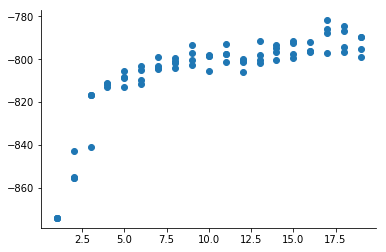

In [64]:
plt.scatter(Cs, lls);

In [91]:
def spatial_patterns(X, exp_mat, DE_mll_results, C, max_iter=10, kernel_space=None):
    ''' Group spatially variable genes into spatial patterns using automatic
    expression histology (AEH).
    '''
    if kernel_space == None:
        l_min, l_max = base.get_l_limits(X)
        l_range = np.logspace(np.log10(l_min), np.log10(l_max), 10)

        Ks = [base.SE_kernel(X, l) for l in l_range]
        
    else:
        raise NotImplementedError('Custom kernels not supported for AEH.')
        
    Y = exp_mat[DE_mll_results['g']].values.T
    
    patterns, cost, Yhats, ll = aeh(X, Y, C, Ks=Ks, max_iter=max_iter)
    
    cres = pd.DataFrame({'g': DE_mll_results['g'],
                         'pattern': new_clusts,
                         'membership': cost.min(1) / N})
    
    Yhats = np.hstack(Yhats)
    Yhats = pd.DataFrame.from_records(Yhats)
    Yhats.index = exp_mat.index
    
    return cres, Yhats

In [92]:
pattern_results, patterns = spatial_patterns(X, res, sres, C=5)

INFO:root:Iteration 1, log likelihood: -862.20
INFO:root:Iteration 2, log likelihood: -821.31
INFO:root:Iteration 3, log likelihood: -809.22
INFO:root:Iteration 4, log likelihood: -807.15
INFO:root:Converged! Finishing...
INFO:root:Iteration 5, log likelihood: -806.62


In [96]:
pattern_results.sort_values('membership', ascending=False).head()

,g,membership,pattern
8913,Cdr1,0.507188,1
8992,Slc17a7,0.280544,1
10713,S100a5,0.275610,2
12591,Ptn,0.261610,2
11114,Nrgn,0.244444,4


In [98]:
pattern_results.pattern.value_counts().head()

2    22
1    16
4    15
3     8
0     6
Name: pattern, dtype: int64

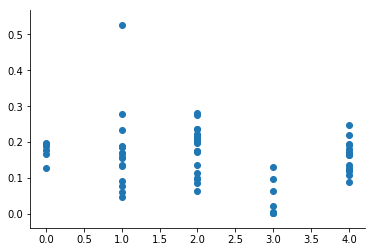

In [99]:
figsize(6, 4)
plt.scatter(pattern_results.pattern, cres.membership);

In [103]:
patterns.shape[1]

5

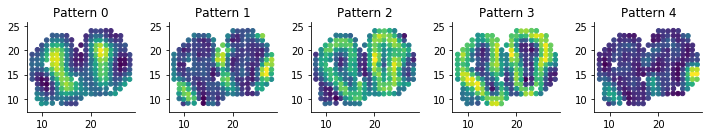

In [116]:
n_rows = 1
figsize(10, 2)
for i in range(patterns.shape[1]):
    plt.subplot(1, 5, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=patterns[i], s=20)
    plt.axis('equal')
    plt.title('Pattern {}'.format(i))
    
plt.tight_layout()

In [118]:
Y.shape

(67, 260)